In [1]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent



[22:18:33 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [2]:
load_dotenv()

True

In [3]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [4]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '195136', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195138', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195137', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211044', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195139', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211045', 'name': 'Games', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195141', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195135', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195140', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211046', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '195142', 'name': '_frontend', 'system': True, 'type': 'docu

In [5]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[22:18:38 -0600] [INFO]: Graph 'SteamGraph' exists.
[22:18:38 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [6]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jQESOIO---', 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [7]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Games/13050_iron_brigade Games/13050_iron_brigade
Users/44482198 Users/44482198
Users/252475396 Users/252475396
Users/252963100 Users/252963100
Users/22045474 Users/22045474
Games/14250_crazy_machines Games/14250_crazy_machines
Games/13268_sword_of_the_stars_ii_enhanced_edition Games/13268_sword_of_the_stars_ii_enhanced_edition
Games/14448_cast_of_the_seven_godsends Games/14448_cast_of_the_seven_godsends
Users/46055854 Users/46055854
Games/14840_over_the_dream Games/14840_over_the_dream


In [8]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [9]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_analyzers
_queues
_aqlfunctions
Users
_jobs
Games
_appbundles
_graphs
_apps
plays
_frontend

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [10]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '187533357', '_id': 'Users/187533357', '_rev': '_jPaYbhm-AM', 'type': 'Users', 'steamid': 187533357}
{'_key': '56973040', '_id': 'Users/56973040', '_rev': '_jPaYbkW--c', 'type': 'Users', 'steamid': 56973040}
{'_key': '18869916', '_id': 'Users/18869916', '_rev': '_jPaYbh2-Ah', 'type': 'Users', 'steamid': 18869916}
----------
Sample Plays Edges:
{'_key': '5719', '_id': 'plays/5719', '_from': 'Users/96014467', '_to': 'Games/12034_medieval_ii_total_war_kingdoms', '_rev': '_jPaYfT2--B', 'weight': 27}
{'_key': '23173', '_id': 'plays/23173', '_from': 'Users/55906572', '_to': 'Games/11491_mark_of_the_ninja', '_rev': '_jPaYgcy--a', 'weight': 8}
{'_key': '31044', '_id': 'plays/31044', '_from': 'Users/92482012', '_to': 'Games/11709_alan_wake', '_rev': '_jPaYgw2--l', 'weight': 10.5}
----------


### Agent

In [11]:
arango_graph = ArangoGraph(db)


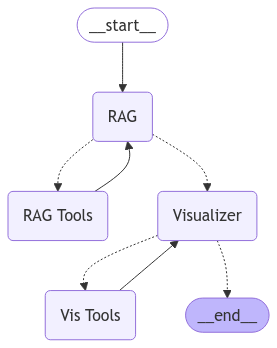

In [12]:
agent = GraphAgent(arango_graph, G_adb)


In [13]:
agent.query_graph("Total number of games in the graph")


Processing Agent State:
{ 'messages': [ HumanMessage(content='Total number of games in the graph', additional_kwargs={}, response_metadata={}, id='976b0f48-3934-4a3a-837d-8a03337fd446')],
  'user_query': 'Total number of games in the graph'}


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Games
FOR game IN Games COLLECT WITH COUNT INTO length RETURN length

AQL Result:
[3600]

> Finished chain.

Processing Agent State:
{ 'messages': [ HumanMessage(content='Total number of games in the graph', additional_kwargs={}, response_metadata={}, id='976b0f48-3934-4a3a-837d-8a03337fd446'),
                AIMessage(content='To find the total number of games in the graph, we need to query the "Games" collection to count the number of documents (each representing a game). Here is the plan:\n\n1. Use the `query_processor` tool to query the "Games" collection and count the total number of documents.\n\nLet\'s execute this plan.', additional_kwargs={'tool_calls': [{'id': 'call_rAHiIK

'Visulaization Done'

In [13]:
agent.query_graph("Find 2nd and 4th Most influential game in the graph and its number of users who played both of them")


Processing Agent State:
{ 'messages': [ HumanMessage(content='Find 2nd and 4th Most influential game in the graph and its number of users who played both of them', additional_kwargs={}, response_metadata={}, id='556cf595-8fce-4ece-8768-ac9c6848bbb4')],
  'user_query': 'Find 2nd and 4th Most influential game in the graph and its '
                'number of users who played both of them'}
Netwrokx Query received:
Find the centrality of games in the graph to identify the 2nd and 4th most influential games.
----------
1) Generating NetworkX code
----------
import networkx as nx

# Calculate the degree centrality for the games in the graph
degree_centrality = nx.degree_centrality(G_adb)

# Filter out only the nodes that are games
games_centrality = {node: centrality for node, centrality in degree_centrality.items() if G_adb.nodes[node]['type'] == 'Games'}

# Sort the games by their centrality in descending order
sorted_games = sorted(games_centrality.items(), key=lambda item: item[1], rev

[21:22:06 -0600] [INFO]: Graph 'SteamGraph' load took 2.775132179260254s


----------
FINAL_RESULT: ('Games/11359_team_fortress_2', 'Games/11590_unturned')
----------
3) Formulating final answer

Processing Agent State:
{ 'messages': [ HumanMessage(content='Find 2nd and 4th Most influential game in the graph and its number of users who played both of them', additional_kwargs={}, response_metadata={}, id='556cf595-8fce-4ece-8768-ac9c6848bbb4'),
                AIMessage(content="To address your query, I will follow these steps:\n\n1. **Identify the Most Influential Games**: Use the `network_analyzer` tool to determine the centrality of games in the graph, which will help identify the 2nd and 4th most influential games.\n   \n2. **Find Users Who Played Both Games**: Once the 2nd and 4th most influential games are identified, use the `query_processor` tool to find the number of users who have played both games.\n\nLet's start with step 1.", additional_kwargs={'tool_calls': [{'id': 'call_pX5dBcbhpfld90YM04G7Up1f', 'function': {'arguments': '{"__arg1":"Find the ce

'The number of users who have played both "Team Fortress 2" and "Unturned" is 500. \n\nTo summarize:\n- 2nd Most Influential Game: "Team Fortress 2"\n- 4th Most Influential Game: "Unturned"\n- Number of users who played both games: 500'

In [ ]:
agent.query_graph("Find the  top 10 users who played a lot  and which games they have played is common most by hours")


Processing Agent State:
{ 'messages': [ HumanMessage(content='Find the  top 10 users who played a lot  and which games they have played is common most by hours', additional_kwargs={}, response_metadata={}, id='f215f92d-4d51-4083-a4f8-0ea346a4fac7')],
  'user_query': 'Find the  top 10 users who played a lot  and which games they '
                'have played is common most by hours'}


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Users, Games, plays
FOR user IN Users
    LET total_hours = SUM(
        FOR play IN plays
            FILTER play._from == user._id
            RETURN play.weight
    )
    SORT total_hours DESC
    LIMIT 10
    RETURN { user_id: user._key, total_hours: total_hours }

AQL Result:
[{'user_id': '73017395', 'total_hours': 11754}, {'user_id': '10599862', 'total_hours': 11651.699999999999}, {'user_id': '100630947', 'total_hours': 10853.2}, {'user_id': '26762388', 'total_hours': 10470.100000000004}, {'user_id': '153382649', 'total_hours': 9640}, 

"Here are the top games most commonly played by the top 10 users based on total hours:\n\n1. **Sid Meier's Civilization V**: 13,197 hours\n2. **Dota 2**: 10,790.4 hours\n3. **Team Fortress 2**: 9,724.7 hours\n4. **Counter-Strike: Global Offensive**: 5,434.6 hours\n5. **Mount & Blade: Warband**: 4,962 hours\n\nThese games are the most popular among the top 10 users with the highest playtime, indicating their gaming preferences."